<a href="https://colab.research.google.com/github/virajpai/llm_experiments/blob/main/Monte_Carlo_Simulation_GPT3_5_Confidence_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install langchain
!pip install openai
!pip install chromadb
!pip install tiktoken
!pip install transformers

In [67]:
from langchain.chains import RetrievalQA
from langchain.evaluation.qa import QAEvalChain

from langchain.document_loaders import WebBaseLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

from langchain.prompts import PromptTemplate
import openai

import re
import pandas as pd
import time

In [68]:
OPEN_API_KEY = ''
openai.api_key = OPEN_API_KEY

In [69]:
url = "https://en.wikipedia.org/wiki/Monte_Carlo_method"

In [70]:
loader = WebBaseLoader(url)
docs = loader.load()

In [71]:
print(docs[0].page_content[:100])





Monte Carlo method - Wikipedia




























Jump to content







Main menu







In [72]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

In [73]:
embeddings = OpenAIEmbeddings(openai_api_key=OPEN_API_KEY)
docsearch = Chroma.from_documents(texts, embeddings)

In [74]:
question = "What is Monte Carlo Simulation?"
docs = docsearch.similarity_search(question)
len(docs)

4

In [75]:
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""

PROMPT = PromptTemplate.from_template(
    template=template
)

In [76]:
chain_type_kwargs = {"prompt": PROMPT}

In [77]:
llm = ChatOpenAI(openai_api_key=openai.api_key,
    model="gpt-3.5-turbo",
    temperature=0.1
)

In [78]:
qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=docsearch.as_retriever(),
                                 chain_type_kwargs=chain_type_kwargs)

In [93]:
query = "Please generate 20 prompts as a question from the context to be answered in 1 or 2 sentences by chatGPT."
res = qa({"query": query})

In [94]:
print(res['result'])

1. What is a natural stochastic process that can be simulated directly or described by stochastic equations?
2. How can the emission of radiation from atoms be modeled using Monte Carlo methods?
3. Can the same computer code be viewed as both a 'natural simulation' and a solution of equations by natural sampling?
4. What are some examples of natural stochastic processes that can be simulated using Monte Carlo methods?
5. How can Monte Carlo methods be used to describe the average behavior of a stochastic process?
6. Can Monte Carlo methods be used to solve stochastic equations?
7. What are the challenges in maintaining distinctions between different types of simulations?
8. How can Monte Carlo methods be applied to simulate the emission of radiation from atoms?
9. Can you explain the concept of 'natural sampling' in the context of Monte Carlo methods?
10. Are there any limitations to using Monte Carlo methods for simulating natural stochastic processes?
11. Can you provide an example o

In [95]:
res.keys()

dict_keys(['query', 'result'])

In [96]:
prompts = res['result'].split('\n')

In [97]:
prompts

['1. What is a natural stochastic process that can be simulated directly or described by stochastic equations?',
 '2. How can the emission of radiation from atoms be modeled using Monte Carlo methods?',
 "3. Can the same computer code be viewed as both a 'natural simulation' and a solution of equations by natural sampling?",
 '4. What are some examples of natural stochastic processes that can be simulated using Monte Carlo methods?',
 '5. How can Monte Carlo methods be used to describe the average behavior of a stochastic process?',
 '6. Can Monte Carlo methods be used to solve stochastic equations?',
 '7. What are the challenges in maintaining distinctions between different types of simulations?',
 '8. How can Monte Carlo methods be applied to simulate the emission of radiation from atoms?',
 "9. Can you explain the concept of 'natural sampling' in the context of Monte Carlo methods?",
 '10. Are there any limitations to using Monte Carlo methods for simulating natural stochastic proce

In [98]:
prompts[:-1]

['1. What is a natural stochastic process that can be simulated directly or described by stochastic equations?',
 '2. How can the emission of radiation from atoms be modeled using Monte Carlo methods?',
 "3. Can the same computer code be viewed as both a 'natural simulation' and a solution of equations by natural sampling?",
 '4. What are some examples of natural stochastic processes that can be simulated using Monte Carlo methods?',
 '5. How can Monte Carlo methods be used to describe the average behavior of a stochastic process?',
 '6. Can Monte Carlo methods be used to solve stochastic equations?',
 '7. What are the challenges in maintaining distinctions between different types of simulations?',
 '8. How can Monte Carlo methods be applied to simulate the emission of radiation from atoms?',
 "9. Can you explain the concept of 'natural sampling' in the context of Monte Carlo methods?",
 '10. Are there any limitations to using Monte Carlo methods for simulating natural stochastic proce

In [109]:
def p2f(x):
  x = x.strip()
  val = re.findall("\d+\.\d+", x)
  return float(val[0])/100

In [118]:
def get_res_conf(p, t):
  q = """Provide me a response in less than 100 words for the given question.
  Also provide in a separate line the true confidence score of the answer in percentage only in following format "Confedence score: xx.xx%
  Also provide in a separate line the accuracy score of the answer in percentage only in following format "Accuracy score: xx.xx%"
  Quetion: """ + p.split(".")[1].strip()

  llm = ChatOpenAI(openai_api_key=openai.api_key,
                   model="gpt-3.5-turbo",
                   temperature=t
  )

  qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=docsearch.as_retriever(),
                                 chain_type_kwargs=chain_type_kwargs)


  res = qa({"query": q})

  response = res["result"]
  # print(response)

  matches = re.findall("(?<=Confidence score: ).*", response)
  confidence = p2f(matches[0])

  matches = re.findall("(?<=Accuracy score: ).*", response)
  accuracy = p2f(matches[0])


  return response, confidence, accuracy


In [119]:
prompts[5]

'6. Can Monte Carlo methods be used to solve stochastic equations?'

In [120]:
get_res_conf(prompts[5], 0)

('Yes, Monte Carlo methods can be used to solve stochastic equations by randomly sampling from the probability distribution of the variables involved in the equation and simulating the system multiple times to obtain statistical estimates. Thanks for asking!\nConfidence score: 95.00%\nAccuracy score: 90.00%',
 0.95,
 0.9)

In [121]:
get_res_conf(prompts[5], 0.5)

('Yes, Monte Carlo methods can be used to solve stochastic equations by randomly sampling the input variables and simulating the system multiple times to obtain statistical estimates of the solution. Thanks for asking!\nConfidence score: 95.00%\nAccuracy score: 90.00%',
 0.95,
 0.9)

In [122]:
get_res_conf(prompts[5], 1)

('Yes, Monte Carlo methods can be used to solve stochastic equations by simulating random processes and generating a large number of samples to estimate the behavior of the equations. This approach allows for the computation of probabilistic quantities and the analysis of complex systems with uncertainty. Thanks for asking!\nConfidence score: 90.00%\nAccuracy score: 90.00%',
 0.9,
 0.9)

In [123]:
%%time
resp_list = []

for p in prompts[:-1]:
  print("prompt: ", p)
  for t in [0, 0.5, 1]:
    print("\ttemperature: ", t)
    r, c, a = get_res_conf(p, t)
    tmp_res = {
        "prompt": p,
        "temprature": t,
        "response": r,
        "confidence": c,
        "accuracy": a
    }

    resp_list.append(tmp_res)
  time.sleep(61)


prompt:  1. What is a natural stochastic process that can be simulated directly or described by stochastic equations?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  2. How can the emission of radiation from atoms be modeled using Monte Carlo methods?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  3. Can the same computer code be viewed as both a 'natural simulation' and a solution of equations by natural sampling?
	temperature:  0
	temperature:  0.5


	temperature:  1
prompt:  4. What are some examples of natural stochastic processes that can be simulated using Monte Carlo methods?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  5. How can Monte Carlo methods be used to describe the average behavior of a stochastic process?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  6. Can Monte Carlo methods be used to solve stochastic equations?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  7. What are the challenges in maintaining distinctions between different types of simulations?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  8. How can Monte Carlo methods be applied to simulate the emission of radiation from atoms?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  9. Can you explain the concept of 'natural sampling' in the context of Monte Carlo methods?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  10. Are there any limitations to using Monte Carlo me

	temperature:  0.5
	temperature:  1
prompt:  17. Can you explain the concept of 'natural simulation' in the context of Monte Carlo methods?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  18. What are some potential applications of Monte Carlo methods in studying natural phenomena?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  19. Can you provide a brief overview of the Monte Carlo method and its relevance to natural stochastic processes?
	temperature:  0
	temperature:  0.5
	temperature:  1
prompt:  20. How do Monte Carlo methods contribute to the field of computational modeling in natural sciences?
	temperature:  0
	temperature:  0.5
	temperature:  1
CPU times: user 13.5 s, sys: 1.64 s, total: 15.2 s
Wall time: 45min 4s


In [124]:
res_df = pd.DataFrame(resp_list)
res_df

,prompt,temprature,response,confidence,accuracy
0,1. What is a natural stochastic process that c...,0.0,The emission of radiation from atoms is a natu...,0.9000,0.8500
1,1. What is a natural stochastic process that c...,0.5,The emission of radiation from atoms is a natu...,0.9500,0.9000
2,1. What is a natural stochastic process that c...,1.0,The emission of radiation from atoms is a natu...,0.9556,0.9000
3,2. How can the emission of radiation from atom...,0.0,The emission of radiation from atoms can be mo...,0.9000,0.8500
4,2. How can the emission of radiation from atom...,0.5,The emission of radiation from atoms can be mo...,0.8000,0.9000
5,2. How can the emission of radiation from atom...,1.0,The emission of radiation from atoms can be mo...,0.9056,0.8889
6,3. Can the same computer code be viewed as bot...,0.0,"Yes, according to Kalos and Whitlock, the same...",1.0000,1.0000
7,3. Can the same computer code be viewed as bot...,0.5,"Yes, the same computer code can be viewed as b...",0.9500,0.9000
8,3. Can the same computer code be viewed as bot...,1.0,"Yes, according to Kalos and Whitlock, the same...",0.9000,0.8600
9,4. What are some examples of natural stochasti...,0.0,Some examples of natural stochastic processes ...,0.9000,0.8500


In [125]:
res_df.groupby('temprature')[['confidence', 'accuracy']].describe()

confidence                                                  \
                count     mean       std  min  25%  50%     75%   max   
temprature                                                              
0.0              20.0  0.91000  0.026157  0.9  0.9  0.9  0.9000  1.00   
0.5              20.0  0.90500  0.045595  0.8  0.9  0.9  0.9500  0.95   
1.0              20.0  0.90556  0.042922  0.8  0.9  0.9  0.9167  1.00   

           accuracy                                                    
              count      mean       std   min   25%   50%   75%   max  
temprature                                                             
0.0            20.0  0.862500  0.035818  0.85  0.85  0.85  0.85  1.00  
0.5            20.0  0.865000  0.046169  0.75  0.85  0.85  0.90  0.95  
1.0            20.0  0.867445  0.046184  0.80  0.85  0.85  0.90  1.00

In [128]:
import seaborn as sns
from matplotlib import pyplot as plt

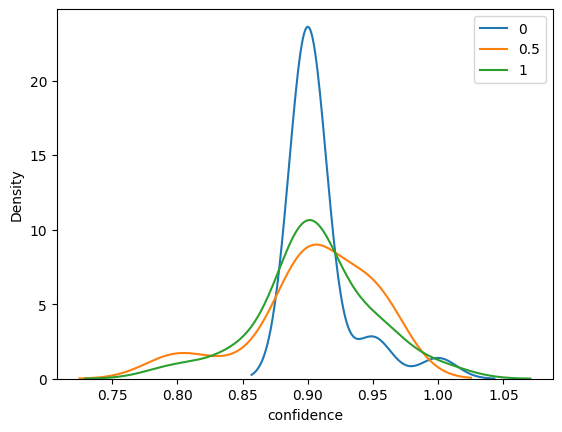

In [131]:
sns.kdeplot(x='confidence', data=res_df[res_df['temprature'] == 0], label='0')
sns.kdeplot(x='confidence', data=res_df[res_df['temprature'] == 0.5], label='0.5')
sns.kdeplot(x='confidence', data=res_df[res_df['temprature'] == 1], label='1')

plt.legend()

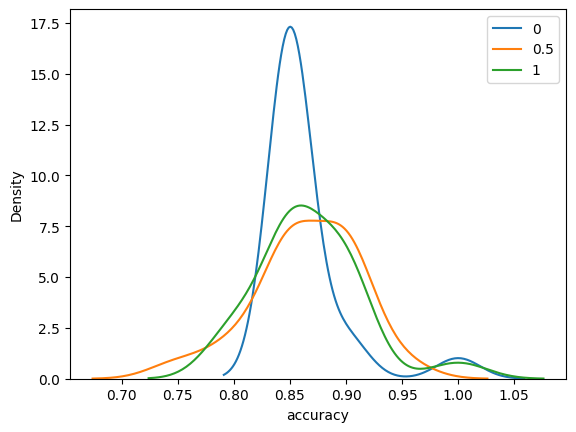

In [132]:
sns.kdeplot(x='accuracy', data=res_df[res_df['temprature'] == 0], label='0')
sns.kdeplot(x='accuracy', data=res_df[res_df['temprature'] == 0.5], label='0.5')
sns.kdeplot(x='accuracy', data=res_df[res_df['temprature'] == 1], label='1')

plt.legend()